<a href="https://colab.research.google.com/github/dimandms/motor_temperatures/blob/refactoring/Motors_Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Goals of the Notebook are:

1. Prepare EDA, understand main features, prepare new features
2. Try to solve bussness cases:

- Estimate current temperature of windings base on measures of currents, voltages, speed, torque and coolant to understand possibility of operations
- Forecast temperatures of windings to understand if the state will be unappropriate

3. Build real-time web application with simulation

https://www.researchgate.net/publication/331976678_Empirical_Evaluation_of_Exponentially_Weighted_Moving_Averages_for_Simple_Linear_Thermal_Modeling_of_Permanent_Magnet_Synchronous_Machines

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from typing import List, Dict, Callable
from enum import Enum
from itertools import product

In [4]:
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy, DataFrameGroupBy
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [83]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/pmsm_temperature_data.csv')

In [84]:
df.head(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4.0
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4.0
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4.0
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4.0
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4.0


In [85]:
df.tail(5)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447033,1.213597,-0.136662,-1.338092,0.315069,1.256531,0.545459,-1.252652,0.463151,0.511155,0.194606,0.420417,0.521998,53.0
447034,1.191186,-0.140209,-1.369103,0.238541,1.241300,0.571222,-1.306237,0.484911,0.513488,0.194769,0.421996,0.525975,53.0
447035,0.385230,-0.240271,-1.423605,0.053742,1.231921,0.614536,-1.443613,0.518100,0.517571,0.194886,0.423170,0.526255,53.0
447036,0.613102,-0.211967,-1.476665,-0.156781,1.235651,0.666284,-1.602808,0.546530,0.520731,0.194969,0.423589,0.526151,53.0
447037,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
df[df.isna().any(axis=1)]

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
447037,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df.dropna(inplace=True)

In [88]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient,447037.0,-0.545941,1.066580,-8.573954,-1.135694,-0.391432,0.297613,2.967117
coolant,447037.0,-0.490912,0.860188,-1.429349,-1.070198,-1.042651,-0.100206,2.271667
u_d,447037.0,-0.312512,0.928724,-1.655373,-1.115274,-0.329154,0.297833,2.274734
u_q,447037.0,0.106391,0.903787,-1.861463,-0.702505,0.006741,0.846473,1.793366
motor_speed,447037.0,0.130303,0.985389,-1.371529,-0.689896,-0.077112,0.941943,2.024164
torque,447037.0,0.324993,0.934409,-3.276957,-0.254833,0.341525,0.845668,3.016971
i_d,447037.0,-0.137845,1.052223,-3.245874,-0.987611,0.038149,0.924246,1.060937
i_q,447037.0,0.328384,0.930032,-3.276311,-0.245712,0.308788,0.820970,2.914185
pm,447037.0,-0.188450,1.110109,-2.631991,-1.027167,-0.156329,0.594209,2.917456
stator_yoke,447037.0,-0.386383,0.934120,-1.834688,-1.095658,-0.480506,0.216848,2.393537


As we see with description, all features scaled. profile_id is just the id of running

### Data exploration
Note 1: Profile_id is corresponde to single experiment. Rows of dataframe represent samples and are sorted by time. Sample values is measured within 0.5 seconds (2 Hz)

Note 2: Target features are tempretures (pm, stator_yoke, stator_tooth, stator_winding)

Questions are:

1. Interesting to know duration of profiles.
2. Find correlations in features
3. Look at time series charts and possible anomalies in it
4. Try to find time series behavior and interconnection
5. Try to find noise in data

In [124]:
MEASURES_IN_SECOND = 2
SECONDS_IN_HOUR = 3600

PLOT_STYLE = "darkgrid"
PLOT_PRIMARY_COLOR = "#333333"
PLOT_SECONDARY_COLOR = "#cc9602"

TEMPERATURE_FEATURES = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
TARGET_FEATURES = TEMPERATURE_FEATURES + ["torque"]

In [90]:
def plot_profile_durations(df: pd.DataFrame):
    grouped_df = (df.groupby('profile_id')
                    .size()
                    .rename('samples')
                    .reset_index())
    
    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(20,3))
        sns.barplot(y='samples', x='profile_id', data=grouped_df, color=PLOT_PRIMARY_COLOR, ax=ax)
        
        hours_ticks: np.ndarray = np.arange(1, 8)
        
        ax.set_yticks(MEASURES_IN_SECOND*SECONDS_IN_HOUR*hours_ticks)
        ax.set_yticklabels([f'{h}' for h in hours_ticks])
        ax.set_ylim((0*MEASURES_IN_SECOND*SECONDS_IN_HOUR, 7*MEASURES_IN_SECOND*SECONDS_IN_HOUR))
        ax.set_ylabel('duration, hours')        

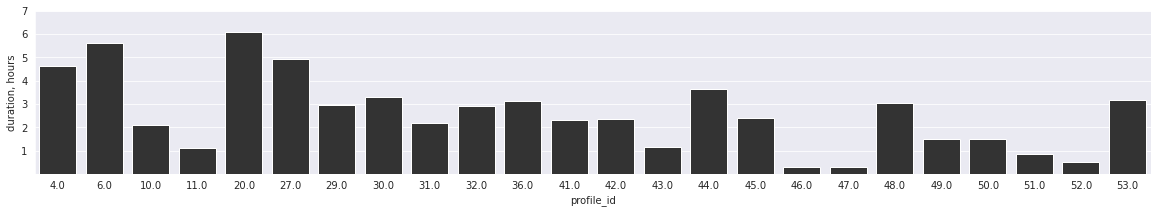

In [91]:
plot_profile_durations(df)

### Conclutions
Here we see that some experiments were very short (about 20 minutes) and potentially they have not any interesting data. Some were long and should have insights in data. Let's look at time series charts of target features

In [98]:
def plot_profile_time_series(df: pd.DataFrame, profile_id: int, num_of_points=None, features=[]):
    if num_of_points is None:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        plt.xlabel("sample")
        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name], color=PLOT_PRIMARY_COLOR)
            ax.set_ylabel(feature_name)

In [94]:
def plot_profile_time_series_single_grid(df: pd.DataFrame, profile_id: int, num_of_points=None, features=[]):
    if num_of_points is None:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()
    else:
      filtered_df=df[features][df.profile_id == profile_id].reset_index()[0:num_of_points]

    with sns.axes_style(PLOT_STYLE):
        _, ax = plt.subplots(1, 1, figsize=(15, 2))
        ax.plot(filtered_df[features[0]], color=PLOT_PRIMARY_COLOR, label=features[0])
        ax.plot(filtered_df[features[1]], color=PLOT_SECONDARY_COLOR, label=features[1])
        ax.set_xlabel('sample')
        ax.legend()

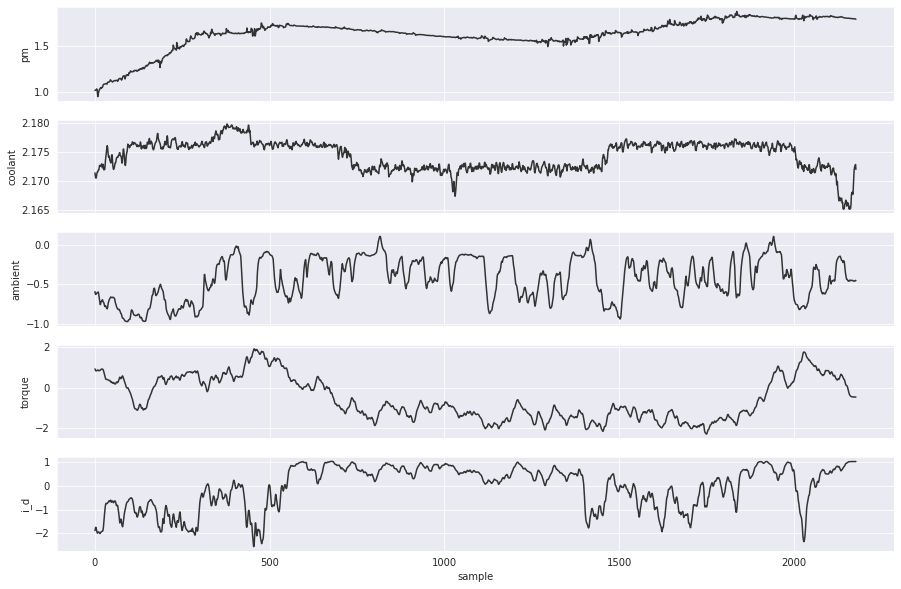

In [99]:
# example of short-time motor running
plot_profile_time_series(df, 46, features = ['pm','coolant','ambient', 'torque', 'i_d'])

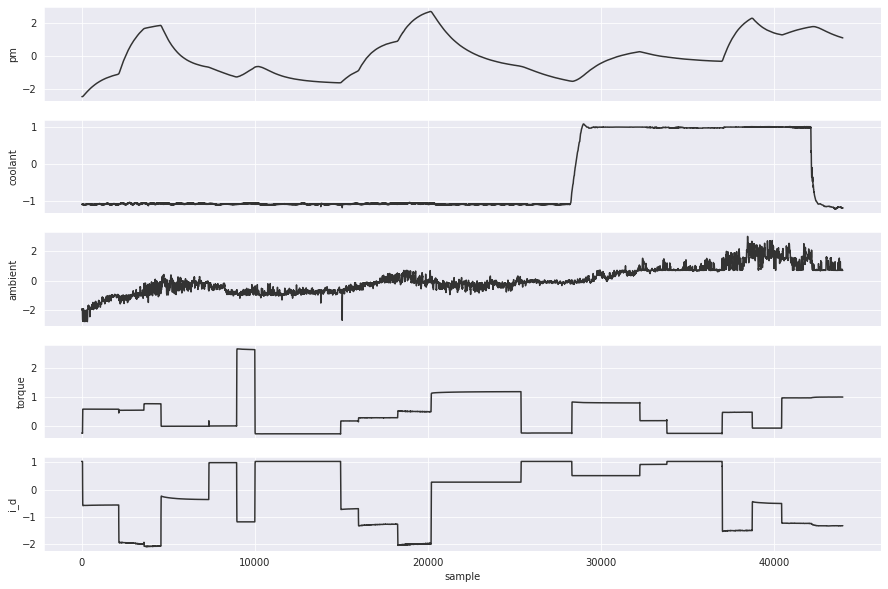

In [100]:
# example of long-time motor running
plot_profile_time_series(df, 20, features=['pm','coolant','ambient', 'torque', 'i_d'])

So, as we see short runnings of motor do not nave any insights of process.

Long term runnings have more interesting process changes. Temperature of stator and rotor exponentially grows/decay after step change of the parameters. But we do not saw any strict dependency in load -> grows or unload -> decay. Maybe it is because of lack of the stator current magnitude (here we could know about Joule–Lenz law: Q ~ I**2, where Q is heat and I is current magnitude)

Also ambient temperature values are noizy, though we need to eliminate that noise with smothing

In [21]:
def calculate_magnitude(value_d: pd.Series, value_q: pd.Series) -> pd.Series:
    return np.sqrt(value_d**2 + value_q**2)


def calculate_apparent_power(current: pd.Series, voltage: pd.Series) -> pd.Series:
    return current * voltage
    

def calculate_active_power(current_d: pd.Series, current_q: pd.Series, voltage_d: pd.Series, voltage_q: pd.Series) -> pd.Series:
    return current_d * voltage_d + current_q * voltage_q
    

def calculate_reactive_power(current_d: pd.Series, current_q: pd.Series, voltage_d: pd.Series, voltage_q: pd.Series) -> pd.Series:
    return current_d * voltage_q - current_q * voltage_d

In [101]:
class StatorParametersTransformer(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.assign(**{
          'current': lambda x: calculate_magnitude(x["i_d"], x["i_q"]),
          'voltage': lambda x: calculate_magnitude(x["u_d"], x["u_q"]),
          'apparent_power': lambda x: calculate_apparent_power(x["current"], x["voltage"]),
          'active_power': lambda x: calculate_active_power(x["i_d"], x["i_q"], x["u_d"], x["u_q"]),
          'reactive_power': lambda x: calculate_reactive_power(x["i_d"], x["i_q"], x["u_d"], x["u_q"]),
        })

In [102]:
df_with_stator_parameters = StatorParametersTransformer().fit_transform(df)

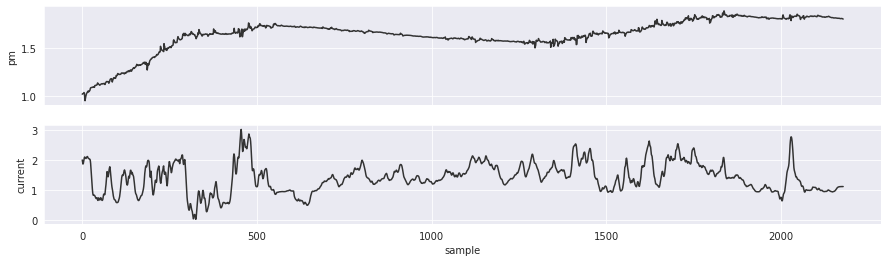

In [104]:
plot_profile_time_series(df_with_stator_parameters, 46, features=['pm','current'])

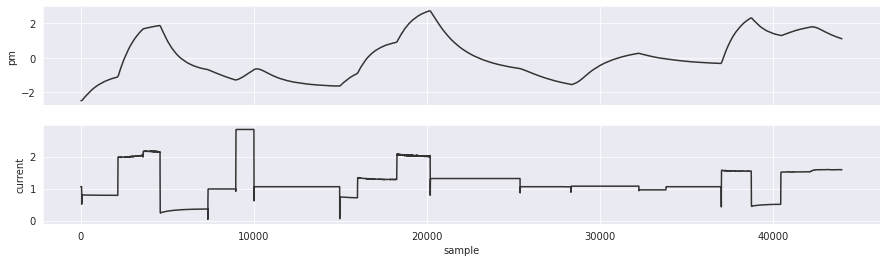

In [103]:
plot_profile_time_series(df_with_stator_parameters, 20, features=['pm','current'])

Now it is clear that steps in current magnitude produce exponential changes in temperatures

### Smoothed features

As we saw above, we need to know history of other parameters to estimate temperature. So we could generate exponential smoothing of current magnitude.

In [29]:
def groupby_and_extract(column: str, feature: str) -> Callable:
  def decorator(func: Callable) -> Callable:
    def wrapper(df: pd.DataFrame) -> DataFrameGroupBy:
      return func(df.groupby("profile_id")[feature])
    return wrapper
  return decorator
  

def define_ewma_calculation_func(feature_name: str, span: int) -> Callable:
  
  # TODO: Fine and clear, but group by for each new feature wired and not efficient. 
  # Need refactoring for multicolumn EWMA.
  @groupby_and_extract("profile_id", feature_name)
  def calculate_ewma(series: SeriesGroupBy) -> pd.Series:
    transformed_series: pd.Series = series.transform(lambda x: x.ewm(span, min_periods=1).mean())
    return transformed_series.reset_index(drop=True)
    
  return calculate_ewma


def define_ewma_features(features: List[str], spans: List[int]) -> Dict[str, Callable]:
  result: Dict[str, Callable] = dict()

  for feature, span in product(features, spans):
    feature_name: str = f"{feature}_ewma_{span}"
    calcualtion_func: Callable = define_ewma_calculation_func(feature, span)
    result[feature_name] = calcualtion_func

  return result

In [30]:
class EwmaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[], spans=[], drop_transformed=True):
        self.columns = columns
        self.spans = spans
        self.drop_transformed = drop_transformed

    def set_params(self, **params):
        self.columns = params["columns"]
        self.spans = params["spans"]
        self.drop_transformed = params["drop_transformed"]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ewma_features: Dict[str, Callable] = define_ewma_features(self.columns, self.spans)
        return (X.assign(**ewma_features).drop(self.columns if self.drop_transformed else [], axis=1))

In [33]:
class Debug(BaseEstimator, TransformerMixin):

    def __init__(self, title):
      self.title = title

    def transform(self, X):
        print(self.title)
        print(f"Total shape: {X.shape}")
        print(f"NaN shape{X[X.isna().any(axis=1)].shape}\n\n")
        return X

    def fit(self, X, y=None, **fit_params):
        return self

step1 : do fit_transform ewma before grid search because GridSearchCV make split on data so ewma not correct

step2 : do grid search with all ewma featres calculated but insert step with KBest, or ColumnSelector

In [216]:
ewma_spans: List[float] = [1300, 3000, 5000]
ewma_columns: List[str] = ['ambient', 'coolant', 'u_d', 'u_q', 
                            'motor_speed', 'i_d','i_q', 'current', 'voltage', 
                            'apparent_power', 'active_power', 'reactive_power']

feature_tarnsformation_pipeline = make_pipeline(
    StatorParametersTransformer(),
    EwmaTransformer(ewma_columns, ewma_spans, drop_transformed=False),
)

new_features_df = feature_tarnsformation_pipeline.fit_transform(df)

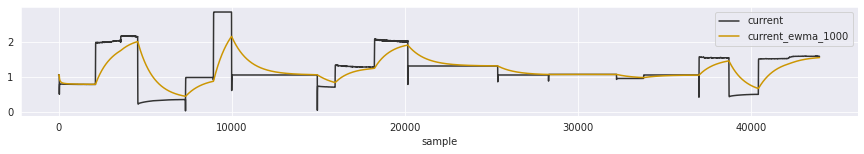

In [108]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['current', 'current_ewma_1000'])

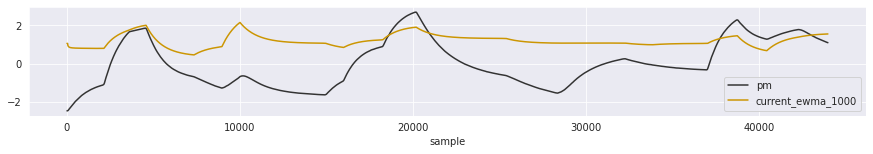

In [109]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['pm', 'current_ewma_1000'])

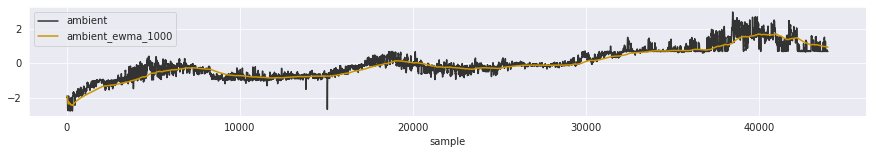

In [117]:
plot_profile_time_series_single_grid(new_features_df.reset_index(), 20, features=['ambient', 'ambient_ewma_1000'])

In [217]:
# Note that profile_id is needed for tests and evaluation, 
# so we will need to deal with it on the modelling steps
# maybe I should solved with moving this column to index

X = new_features_df.drop(columns=TARGET_FEATURES + ["profile_id"])
y = new_features_df["pm"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [221]:
# Use SelectKBest out of feature_tarnsformation_pipeline because of DataFrame interface
# We can change k and see how it influence on results
# K='all' is for all features selected
# TODO: influde in grid search
selector = SelectKBest(f_regression, k='all')
selector.fit_transform(X_train, y_train)
mask = selector.get_support()
selected_features = X_train.columns[mask]

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

selected_features

Index(['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q',
       'current', 'voltage', 'apparent_power', 'active_power',
       'reactive_power', 'ambient_ewma_1300', 'ambient_ewma_3000',
       'ambient_ewma_5000', 'coolant_ewma_1300', 'coolant_ewma_3000',
       'coolant_ewma_5000', 'u_d_ewma_1300', 'u_d_ewma_3000', 'u_d_ewma_5000',
       'u_q_ewma_1300', 'u_q_ewma_3000', 'u_q_ewma_5000',
       'motor_speed_ewma_1300', 'motor_speed_ewma_3000',
       'motor_speed_ewma_5000', 'i_d_ewma_1300', 'i_d_ewma_3000',
       'i_d_ewma_5000', 'i_q_ewma_1300', 'i_q_ewma_3000', 'i_q_ewma_5000',
       'current_ewma_1300', 'current_ewma_3000', 'current_ewma_5000',
       'voltage_ewma_1300', 'voltage_ewma_3000', 'voltage_ewma_5000',
       'apparent_power_ewma_1300', 'apparent_power_ewma_3000',
       'apparent_power_ewma_5000', 'active_power_ewma_1300',
       'active_power_ewma_3000', 'active_power_ewma_5000',
       'reactive_power_ewma_1300', 'reactive_power_ewma_3000',
       

In [222]:
model_pipline = Pipeline([
  ("regressor", Ridge())
])

params_grid = {
    "regressor__alpha": np.logspace(-8, 3, num=12, base=10),
    "regressor__fit_intercept": [True, False],
}

model = GridSearchCV(model_pipline, 
                     params_grid, 
                     scoring=make_scorer(r2_score), 
                     n_jobs=-1,
                     cv=10,
                     verbose=1,
                     refit=True,
                     return_train_score=True
                     )

model.fit(X_train_filtered, y_train)

cv_results_df = pd.DataFrame(model.cv_results_)
cv_results_df[["param_regressor__alpha", "param_regressor__fit_intercept", 
               "mean_train_score","std_train_score",
               "mean_test_score","std_test_score", 
               "rank_test_score"]]

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   43.6s finished


,param_regressor__alpha,param_regressor__fit_intercept,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
0,1e-08,True,0.908382,0.000263,0.908344,0.002373,6
1,1e-08,False,0.908304,0.000264,0.908266,0.002384,13
2,1e-07,True,0.908382,0.000263,0.908344,0.002373,5
3,1e-07,False,0.908304,0.000264,0.908266,0.002384,12
4,1e-06,True,0.908382,0.000263,0.908344,0.002373,4
5,1e-06,False,0.908304,0.000264,0.908266,0.002384,11
6,1e-05,True,0.908382,0.000263,0.908344,0.002373,3
7,1e-05,False,0.908304,0.000264,0.908266,0.002384,10
8,0.0001,True,0.908382,0.000263,0.908344,0.002373,2
9,0.0001,False,0.908304,0.000264,0.908266,0.002384,9


In [223]:
model.best_estimator_.named_steps['regressor'].coef_

array([-1.44841536e-02, -1.75985276e-01,  1.06927057e-01, -2.17568907e-01,
        2.61692017e-01,  1.74044335e-01,  8.47375280e-02, -5.20613950e-02,
        2.00622526e-03, -7.77109822e-02,  2.83709040e-02,  8.46195004e-02,
       -2.89968748e-01,  3.02199026e+00, -2.55547790e+00,  8.78475231e-01,
       -8.82396599e-01,  7.77348544e-01, -1.79726524e+00,  4.24792374e+00,
       -3.28142428e+00, -1.12640663e-01, -2.20981273e+00,  6.57463667e-01,
       -4.80279901e-02,  4.02036708e+00, -1.91215964e+00, -6.51476031e-01,
        2.68146420e+00, -1.30808622e+00, -1.48535926e+00,  4.50445349e+00,
       -3.29201063e+00, -6.39043576e-01,  5.87976588e+00, -5.15417345e+00,
       -1.31508905e+00,  6.42329578e+00, -4.84606695e+00,  1.21892858e+00,
       -5.51941679e+00,  4.19282926e+00, -5.08179265e-01,  1.08439799e+00,
       -1.06859838e+00, -3.33706257e-01,  1.51562282e+00, -7.05925533e-01])

Let's prepare helpers to eveluate our experiments with models

In [204]:
def evaluate_test(estimator, score, X_test, y_test):
  y_pred = estimator.predict(X_test)
  return score(y_test, y_pred)


def score_on_profiles(df, estimator, score, selected_features, profile_ids=None):
  profile_ids_to_score = df.profile_id.unique() if profile_ids is None else profile_ids
  
  result = list()
  for profile_id in profile_ids_to_score:
     df_profile = df[df.profile_id == profile_id]
     profile_score = evaluate_test(estimator, score, df_profile[selected_features], df_profile["pm"])
     result.append((int(profile_id), profile_score))

  return result

# df should have profile_id
def plot_fitted_values(df, estimator, selected_features, profile_ids=None):
  profile_ids_to_plot = df.profile_id.unique() if profile_ids is None else profile_ids

  with sns.axes_style(PLOT_STYLE):
      _, axes = plt.subplots(len(profile_ids_to_plot), 
                             1, 
                             figsize=(15, len(profile_ids_to_plot)*2))
      plt.xlabel("sample")

      for ax, profile_id in zip(axes, profile_ids_to_plot):
        df_profile = df[df.profile_id == profile_id]
        y_pred = estimator.predict(df_profile[selected_features]) #need just selected features
        y_true = df_profile["pm"].values

        ax.plot(y_true, color=PLOT_PRIMARY_COLOR)
        ax.plot(y_pred, color=PLOT_SECONDARY_COLOR)
        ax.set_ylabel(f"pm: pid {profile_id}")

In [224]:
score = evaluate_test(model.best_estimator_, r2_score, X_test_filtered, y_test)
f"Evaluation on test dataset result: {score: 0.3f}"

'Evaluation on test dataset result:  0.908'

In [225]:
scores = score_on_profiles(new_features_df, model.best_estimator_, r2_score, selected_features)
scores_df = pd.DataFrame(scores, columns=["profile_id", "score"]).sort_values(by=['score'], ascending=False).reset_index(drop=True)
scores_df

,profile_id,score
0,20,0.968196
1,32,0.959990
2,27,0.944702
3,4,0.943329
4,44,0.908295
5,6,0.908048
6,30,0.866156
7,29,0.865504
8,45,0.834010
9,48,0.792863


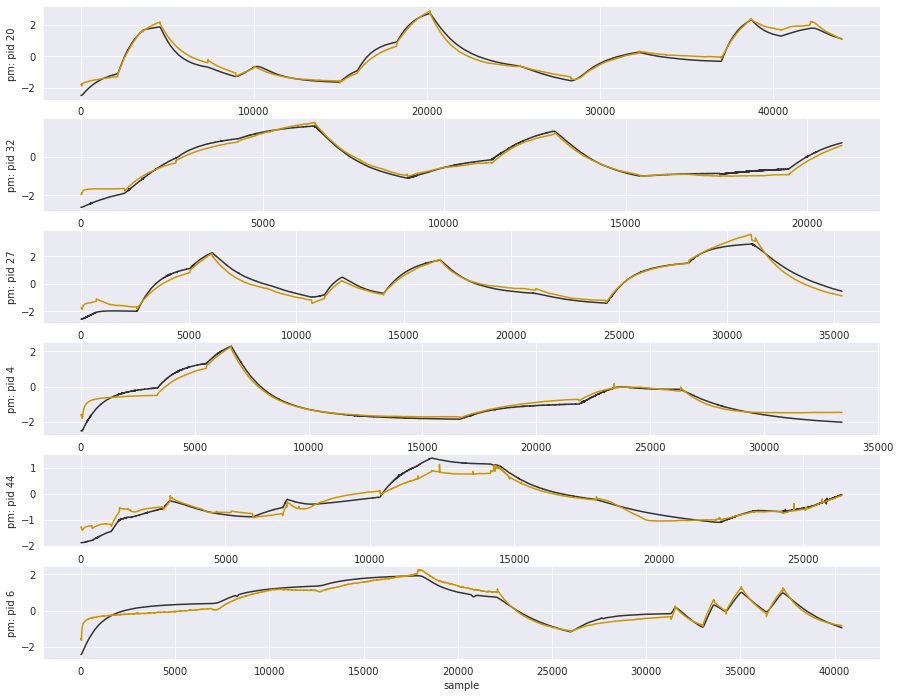

In [226]:
# good fittings:
best_5_fitted_profiles_id = scores_df.loc[0:5, "profile_id"].values
plot_fitted_values(new_features_df, model.best_estimator_, selected_features, best_5_fitted_profiles_id)

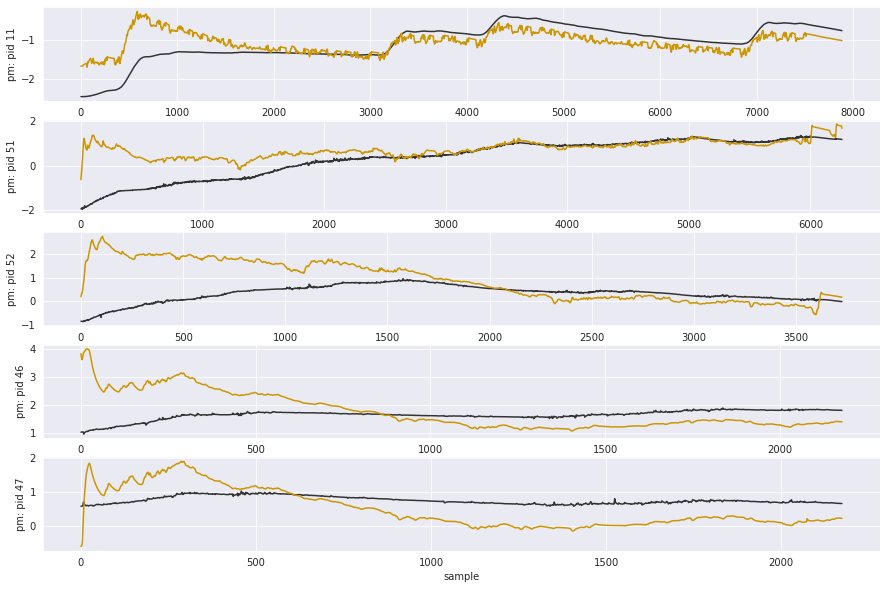

In [227]:
# worst fittings:
worst_5_fitted_profiles_id = scores_df.iloc[-5:]["profile_id"].values
plot_fitted_values(new_features_df, model.best_estimator_, selected_features, worst_5_fitted_profiles_id)

### Concluton on Ridge

1. Long runnings predited very well. It's is because of step load/unload
2. Due to exponential smoothing in our futures, prediction accuracy good after some time since start
3. Due to p.2, short runnings prediction is uwful
4. In long runnings we can see some weak predictons
5. Error distributed not normally

### Ways to improve

1. More complex model
2. Future selection (some not needed)
3. Different loss function / metric